## Задание
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

Все файлы с данными я выложил на свой гугл диск. Для начала присоединяем google disc

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.0 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Загружаем данные

In [ ]:
import pandas as pd

path = '/content/drive/MyDrive/отзывы за лето.xls'
data = pd.read_excel(path)
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
data.shape

(20659, 3)

In [ ]:
data['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

Для удобства работы с НН заменяем лейблы

In [ ]:
data['Rating'] = data['Rating'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})

In [ ]:
data['Rating'].value_counts()

4    14586
0     2276
3     2138
2      911
1      748
Name: Rating, dtype: int64

устанавливаем нужные библиотеки

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 8.2 MB 45.0 MB/s 


In [ ]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=d3edc98b7739d8c49c5cdc92cc04f45c6b6f2e273f264993aef83ba45aa77ffe
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [ ]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

Функция для предобработки текста

In [ ]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = txt.lower()
    #txt = re.sub("\sне", "не", txt)
    txt = word_tokenize(txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt if word not in sw]
    return " ".join(txt)

Предобрабатываем тексты

In [ ]:
data['Content'] = data['Content'].apply(preprocess_text)
data.head()

,Rating,Content,Date
0,4,it just works !,2017-08-14
1,3,целое удобноной приложение ... минус хотеть бо...,2017-08-14
2,4,отлично,2017-08-14
3,4,зависать 1 % работа антивирус . . ранее пользо...,2017-08-14
4,4,"удобно , работать быстро .",2017-08-14


Готовим данные к обучению

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

train_corpus = " ".join(data["Content"])
tokens = word_tokenize(train_corpus, )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
len(tokens)

140244

In [ ]:
#max_words = 5000
max_len = 100
num_classes = 5

# Training
epochs = 5
batch_size = 32
print_batch_n = 100

Создаем словарь уникальных токенов в корпусе

In [ ]:
from nltk.probability import FreqDist
dist = FreqDist(tokens)
tokens_freq = [pair[0] for pair in dist.most_common()]

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_freq, 1)).items()}

функция перевода текста в последовательность с паддингом

In [ ]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

бьем на трейн и тест

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data['Content'], data['Rating'], test_size=0.33, random_state=42, stratify=data['Rating'])

переводим тексты в трейне в последовательности

In [ ]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in x_train], dtype=np.int32)

In [ ]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.metrics import SparseCategoricalAccuracy, categorical_crossentropy 
from keras.callbacks import EarlyStopping  
from keras.losses import SparseCategoricalCrossentropy

Делаем первую часть задания

2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/

Вопрользуемся предобученными векторами ruscorpora_upos_skipgram_300_5_2018

In [ ]:
path_pretrained_vectors = '/content/drive/MyDrive/ruscorpora_upos_skipgram_300_5_2018.vec'

Создадим словарь эмбеддингов для слов в ruscorpora_upos_skipgram_300_5_2018

In [ ]:
import os

embeddings_index = {}
f = open(path_pretrained_vectors)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 195072 word vectors.


Т.к. в ruscorpora_upos_skipgram_300_5_2018 имеет формат ключа=СЛОВО_ЧАСТЬ РЕЧИ, то заменим ключ, где останется только слово, чтобы можно было мэчить с токенами в корпусе

In [ ]:
keys = list(embeddings_index.keys())
for key in keys:
    new_key = key.split(sep='_')[0]
    embeddings_index[new_key] = embeddings_index.pop(key)

In [ ]:
len(vocabulary)

10154

Создаем матрицу эмбеддингов для токенов из корпуса. Если токен будет найдет среди ключей ruscorpora_upos_skipgram_300_5_2018, то соответствующий эмбеддинг будет добавлен в мтарицу, иначе - останется нудевой вектор

In [ ]:
EMBEDDING_DIM=300
embedding_matrix = np.zeros((len(vocabulary)+1, EMBEDDING_DIM))
for i, key in enumerate(vocabulary.keys()):
    embedding_vector = embeddings_index.get(key)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(10155, 300)

Создаем модель, в слой эмбеддинга передаем передаем матрицу с предобученными эмбеддингами

In [ ]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
model.add(Conv1D(128, 4))
model.add(Activation("relu"))
model.add(Conv1D(256, 3))
model.add(Activation("relu"))
model.add(Conv1D(256, 2))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Обучаем

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 67s 164ms/step - loss: 0.7991 - accuracy: 0.7318 - val_loss: 0.7139 - val_accuracy: 0.7451
Epoch 2/5
390/390 [==============================] - 58s 149ms/step - loss: 0.7122 - accuracy: 0.7546 - val_loss: 0.7045 - val_accuracy: 0.7567
Epoch 3/5
390/390 [==============================] - 59s 150ms/step - loss: 0.6754 - accuracy: 0.7663 - val_loss: 0.6951 - val_accuracy: 0.7603
Epoch 4/5
390/390 [==============================] - 59s 152ms/step - loss: 0.6421 - accuracy: 0.7757 - val_loss: 0.7053 - val_accuracy: 0.7560
Epoch 5/5
390/390 [==============================] - 58s 149ms/step - loss: 0.6108 - accuracy: 0.7846 - val_loss: 0.7213 - val_accuracy: 0.7487


Для проверки на тесте переводим тестовые тексты в последовательности

In [ ]:
x_test = np.asarray([text_to_sequence(text, max_len) for text in x_test], dtype=np.int32)

Делаем предсказание и выводим метрики по классам

In [ ]:
import numpy as np
pred = model.predict(x_test, batch_size=batch_size)

In [ ]:
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.42      0.78      0.54       751
           1       0.00      0.00      0.00       247
           2       0.00      0.00      0.00       301
           3       0.24      0.06      0.10       705
           4       0.86      0.93      0.90      4814

    accuracy                           0.75      6818
   macro avg       0.30      0.36      0.31      6818
weighted avg       0.68      0.75      0.70      6818



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


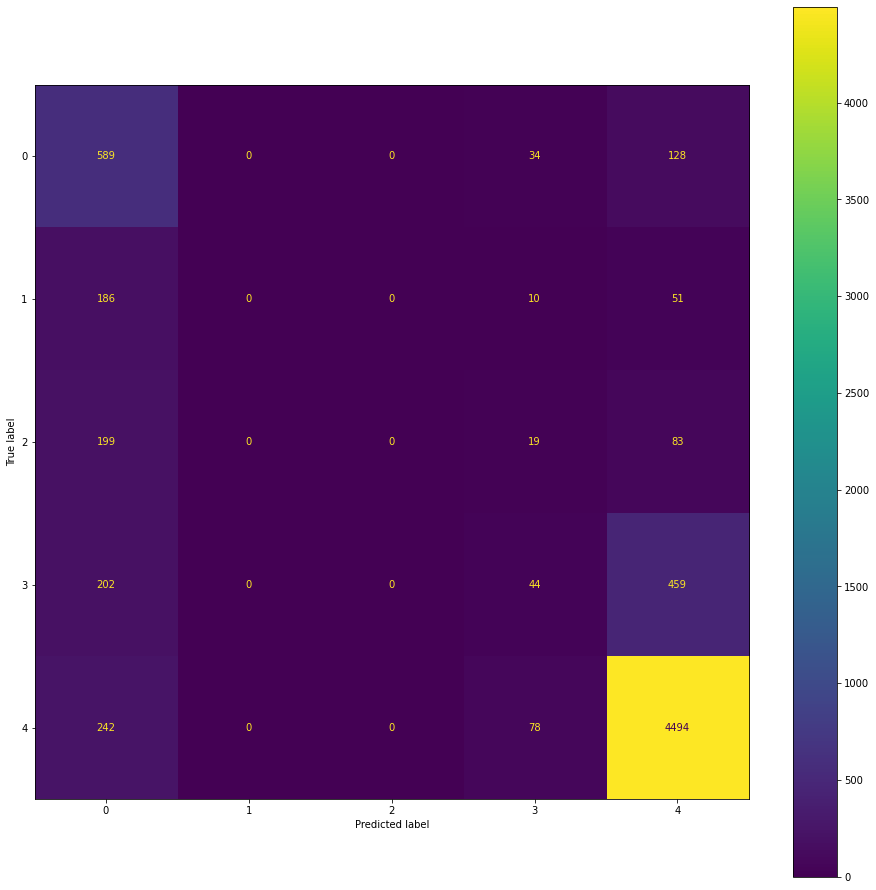

In [ ]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

Модель неплохо справилась с пердсказанием 4-го самого крупного класса (хорошая точность и полнота). С остальными классами не очень. Но и данных по ним было очень мало.

Делаем вторую часть задания

2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Создаем модель с дефолтным слоем Embedding

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(vocabulary)+1, output_dim=256, input_length=max_len))
model.add(Conv1D(128, 4))
model.add(Activation("relu"))
model.add(Conv1D(256, 3))
model.add(Activation("relu"))
model.add(Conv1D(256, 2))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Обучаем

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/5
390/390 [==============================] - 78s 199ms/step - loss: 0.7502 - accuracy: 0.7524 - val_loss: 0.6673 - val_accuracy: 0.7718
Epoch 2/5
390/390 [==============================] - 77s 196ms/step - loss: 0.6241 - accuracy: 0.7808 - val_loss: 0.6804 - val_accuracy: 0.7697
Epoch 3/5
390/390 [==============================] - 76s 195ms/step - loss: 0.5604 - accuracy: 0.7991 - val_loss: 0.7052 - val_accuracy: 0.7617
Epoch 4/5
390/390 [==============================] - 77s 198ms/step - loss: 0.5150 - accuracy: 0.8165 - val_loss: 0.7198 - val_accuracy: 0.7610
Epoch 5/5
390/390 [==============================] - 76s 194ms/step - loss: 0.4718 - accuracy: 0.8329 - val_loss: 0.7773 - val_accuracy: 0.7567


делаем предсказания и выводим метрики

In [ ]:
import numpy as np
pred = model.predict(x_test, batch_size=batch_size)

In [ ]:
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))
pred_label[:5]

[0, 4, 4, 4, 4]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

           0       0.54      0.61      0.57       751
           1       0.20      0.05      0.08       247
           2       0.22      0.27      0.24       301
           3       0.27      0.21      0.23       705
           4       0.89      0.92      0.91      4814

    accuracy                           0.75      6818
   macro avg       0.42      0.41      0.41      6818
weighted avg       0.73      0.75      0.74      6818



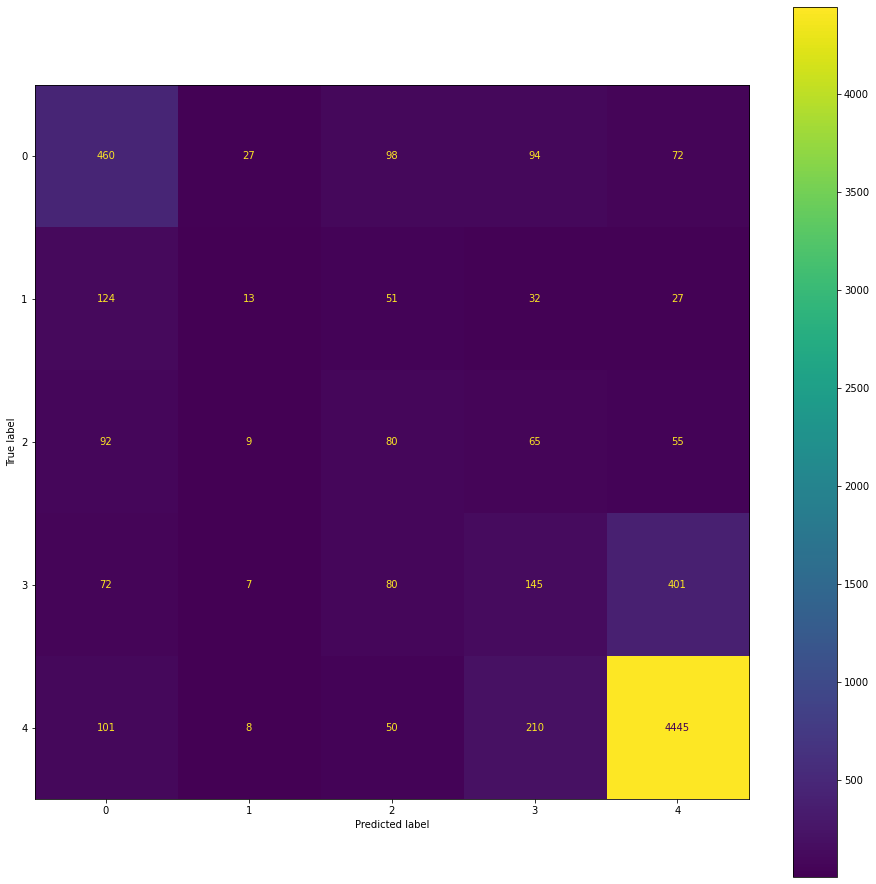

In [ ]:
conf_matrix = confusion_matrix(y_test, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,16))
disp.plot(ax=ax)
plt.show()

Модель с дефолтной инициализацией слоя Embedding справилась чуть лучше. Наверняка это связано с тем, что не все токены из корпуса были найдены среди предобученных векторов и было достаточно много нулевых